<center><h1 style="font-size: 28px;"><b>Bloc n°4 - Analyse prédictive de données non-structurées par l'intelligence artificielle
</b></h1></center>

## 1. Travail préparatoire

## 1.1 Imports des packages nécéssaires

In [ ]:
!pip install split-folders


In [ ]:
# Paramètrage spécifique pour fonctionner avec google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Obtenir et enregistrer le chemin de travail par défaut
user_path = os.path.join(os.getcwd(), "drive", "MyDrive")

print(user_path)

/content/drive/MyDrive


In [ ]:
# GOOGLE Colab ONLY

import splitfolders
#3 dossiers (train, val, test)
splitfolders.ratio(os.path.join(user_path, "Animaux"),
                   output = os.path.join(user_path, "Animaux_SPLIT"),
                   seed = 42,
                   ratio = (.7, .2, .1), #pour 3 args, train/val/test
                   group_prefix = None,
                   move = False)

Copying files: 6000 files [02:20, 42.57 files/s] 


## 1.2 Import des librairies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications import EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3

## 3. Traitement d'images

### 3.1 Configuation des chemin vers les dossiers contenant les images

In [ ]:
# GOOGLE Colab ONLY
train_dir = os.path.join(user_path, "Animaux_SPLIT", "train")
val_dir = os.path.join(user_path, "Animaux_SPLIT", "val")
test_dir = os.path.join(user_path, "Animaux_SPLIT", "test")


### 3.2 Data augmentation techniques

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [0.9, 1.25],
    brightness_range = [0.5, 1.5],
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = ImageDataGenerator(
    rescale = 1./255)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

### 3.3 Définition des train et val générators

In [ ]:
# Variables
batch_size = 32
height = 240
width = 240
# images de taille 240x240 px avec 3 canaux de couleur RGB automatiquement
image_shape = (height, width)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

Found 4200 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## 4. Construction du modèle

In [ ]:
# Modèle utilisé

model_name = "EfficientNetV2B1"
ModelNameFunc = globals()[model_name]

# Arichitecture du modèle
l1_neurons = 32                 # Number of neurons on layer 1 (deeper)
l1_activation = "relu"
dropout = 0.4                   # 0.2 - 0.5
l2_neurons = 16                 # Number of neurons on layer 2
l2_activation = "relu"
output_neurons = 3              # This layer will have 3 neurons or units fully connected. In line with our 3 classes.
output_activation = "softmax"

# Metrics (parameter average = "macro" by default )
precision = keras.metrics.Precision(name="Precision")
recall = keras.metrics.Recall(name="Recall")
#f1 = keras.metrics.F1Score(name = "F1")
auc = keras.metrics.AUC(name="AUC")


# TRAIN : model.compile
compile_optimizer = "RMSprop"                  # Test : Nadam, RMSprop, SGD
compile_loss = "categorical_crossentropy"   # More than 2 classes, so categorical
compile_metrics = ["accuracy", precision, recall, auc]

# TRAIN : model.fit
epochs = 30
verbose = 1

# FINE TUNE : model.compile
ft_compile_optimizer = RMSprop(learning_rate = 1e-5)
# ft_compile_optimizer : Very low learning rate. Test : Nadam, RMSprop, SGD
ft_compile_loss = "categorical_crossentropy"
ft_compile_metrics = ["accuracy", precision, recall, auc]

# FINE TUNE : model.fit
ft_epochs = 15
ft_verbose = 1

# Sauvegarde : File Path .h5
fileh5_path = os.path.join(user_path, f"{model_name}_H5_Model", f"{model_name}_TRAIN_ManualSave.h5")
ft_fileh5_path = os.path.join(user_path, f"{model_name}_H5_Model", f"{model_name}_FT_ManualSave.h5")

## 4.1 Définition des optimisations

### 4.1.1 Optimisation de l'entrainement

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Définition et paramètrage du early stopping
# Définir l'arrêt anticipé (early stopping)
early_stopping = EarlyStopping(
    monitor = "val_loss",        # Métrique à surveiller
    patience = 5,                # Nombre d'époques sans amélioration (environ 10% du nombre total d'époques)
    verbose = 1,                 # Mode de verbosité (0, 1, ou 2)
    restore_best_weights = True  # Restaurer les poids du modèle à la meilleure époque
)

# Définir le planificateur de taux d'apprentissage (learning rate scheduler)
lr_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",       # Métrique à surveiller
    factor = 0.2,               # Facteur par lequel réduire le taux d'apprentissage
    patience = 5,               # Nombre d'époques sans amélioration (par défaut = 10)
    verbose = 1,                # Mode de verbosité (0, 1, ou 2)
    min_lr = 1e-6               # Taux d'apprentissage minimum
)

# Définir le rappel du point de contrôle du modèle (model checkpoint callback)
checkpoint = ModelCheckpoint(
    filepath = os.path.join(user_path, f"{model_name}_H5_Model", f"{model_name}_TRAIN_MCPBest.h5"),
    monitor = "val_loss",       # Métrique à surveiller
    save_freq = "epoch",        # Par défaut = epoch
    save_weights_only = False,  # Par défaut = False
    save_best_only = True,      # Sauvegarder uniquement si la métrique surveillée s'améliore
    mode = "min",               # "min" si la perte est surveillée, "max" si la précision est surveillée
    verbose = 1                 # Mode de verbosité (0, 1, ou 2)
)

# Définir les journaux TensorBoard
log_dir = os.path.join(user_path, f"{model_name}_LOGS_TRAIN")
tensorboard = TensorBoard(log_dir)

# Inclure ces rappels dans la liste des rappels (callbacks list)
callbacks_list = [early_stopping, lr_scheduler, checkpoint, tensorboard]


### 4.1.2 Définition du Fine Tune

In [ ]:
# Définir l'arrêt anticipé (early stopping)
ft_early_stopping = EarlyStopping(
    monitor = "val_loss",        # Métrique à surveiller
    patience = 3,                # Nombre d'époques sans amélioration
    verbose = 1,                 # Mode de verbosité (0, 1, ou 2)
    restore_best_weights = True  # Restaurer les poids du modèle à la meilleure époque
)

# Définir le planificateur de taux d'apprentissage (learning rate scheduler)
ft_lr_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",       # Métrique à surveiller
    factor = 0.2,               # Facteur par lequel réduire le taux d'apprentissage
    patience = 3,               # Nombre d'époques sans amélioration (par défaut = 10)
    verbose = 1,                # Mode de verbosité (0, 1, ou 2)
    min_lr = 1e-6               # Taux d'apprentissage minimum
)

# Définir le rappel du point de contrôle du modèle (model checkpoint callback)
ft_checkpoint = ModelCheckpoint(
    filepath = os.path.join(user_path, f"{model_name}_H5_Model", f"{model_name}_FT_MCPBest.h5"),
    monitor = "val_loss",       # Métrique à surveiller
    save_freq = "epoch",        # Par défaut = epoch
    save_weights_only = False,  # Par défaut = False
    save_best_only = True,      # Sauvegarder uniquement si la métrique surveillée s'améliore
    mode = "min",               # "min" si la perte est surveillée, "max" si la précision est surveillée
    verbose = 1                 # Mode de verbosité (0, 1, ou 2)
)

# Définir les journaux TensorBoard
ft_log_dir = os.path.join(user_path, f"{model_name}_LOGS_FT")
ft_tensorboard = TensorBoard(ft_log_dir)

# Inclure ces rappels dans la liste des rappels (callbacks list)
ft_callbacks_list = [ft_early_stopping, ft_lr_scheduler, ft_checkpoint, ft_tensorboard]


## 4.2 Pré-entrainement du modèle

### 4.2.1 Instancier un modèle de base avec un modèle pré-entraîné et des poids


In [ ]:
# Instancier d'abord un modèle de base avec des poids pré-entraînés
base_model = ModelNameFunc(
    include_top = False,
    weights = "imagenet",
    include_preprocessing = False,
    input_shape = (height, width, output_neurons)
)


In [ ]:
display(base_model.input)

<KerasTensor: shape=(None, 240, 240, 3) dtype=float32 (created by layer 'input_2')>

### 4.2.2 Définir la nouvelle architecture supérieure###

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(l1_neurons, activation = l1_activation)(x)
x = Dropout(dropout)(x)
x = Dense(l2_neurons, activation = l2_activation)(x)
x = BatchNormalization()(x)

predictions = Dense(output_neurons, activation = output_activation)(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
print(model.input_shape)

(None, 240, 240, 3)


### 4.2.3 Compilation du modèle

In [ ]:
model.compile(
    optimizer = compile_optimizer,
    loss = compile_loss,
    metrics = compile_metrics
)

### 4.2.4 Pré-entrainement du modèle

In [ ]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = epochs,
    verbose = verbose,
    callbacks = callbacks_list
)

# Save the model
model.save(fileh5_path)

Epoch 1/30
132/132 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8810 - Precision: 0.9031 - Recall: 0.8569 - AUC: 0.9679
Epoch 1: val_loss improved from inf to 0.15602, saving model to /content/drive/MyDrive/EfficientNetV2B1_H5_Model/EfficientNetV2B1_TRAIN_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 199s 1s/step - loss: 0.3480 - accuracy: 0.8810 - Precision: 0.9031 - Recall: 0.8569 - AUC: 0.9679 - val_loss: 0.1560 - val_accuracy: 0.9533 - val_Precision: 0.9571 - val_Recall: 0.9492 - val_AUC: 0.9927 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9302 - Precision: 0.9432 - Recall: 0.9205 - AUC: 0.9841
Epoch 2: val_loss did not improve from 0.15602
132/132 [==============================] - 123s 928ms/step - loss: 0.2285 - accuracy: 0.9302 - Precision: 0.9432 - Recall: 0.9205 - AUC: 0.9841 - val_loss: 0.1785 - val_accuracy: 0.9392 - val_Precision: 0.9468 - val_Recall: 0.9342 - val_AUC: 0.9906 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9464 - Precision: 0.9511 - Recall: 0.9410 - AUC: 0.9899
Epoch 3: val_loss improved from 0.15602 to 0.04820, saving model to /content/drive/MyDrive/EfficientNetV2B1_H5_Model/EfficientNetV2B1_TRAI

### 4.2.5 Evaluation du pré-entrainement

In [ ]:
# Évaluer le modèle sur les données de test à l'aide de la fonction `evaluate`
print("Evaluate on Test Data")
results = model.evaluate(test_generator, batch_size = batch_size)

Evaluate on Test Data
19/19 [==============================] - 7s 363ms/step - loss: 0.0533 - accuracy: 0.9867 - Precision: 0.9883 - Recall: 0.9850 - AUC: 0.9979


### 4.2.6 Visualisation de l'accuracy et de la "loss"

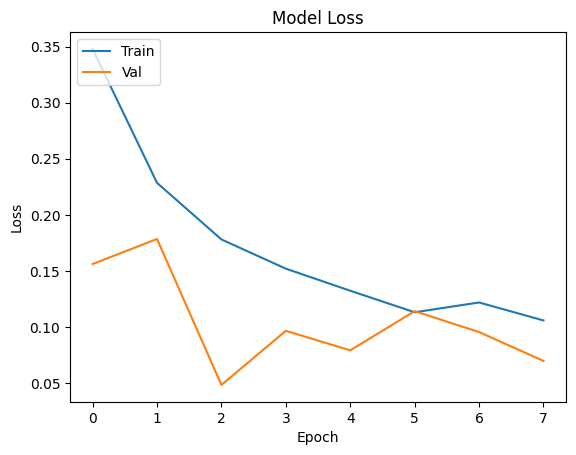

In [ ]:
# Graphique de la "Loss"
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

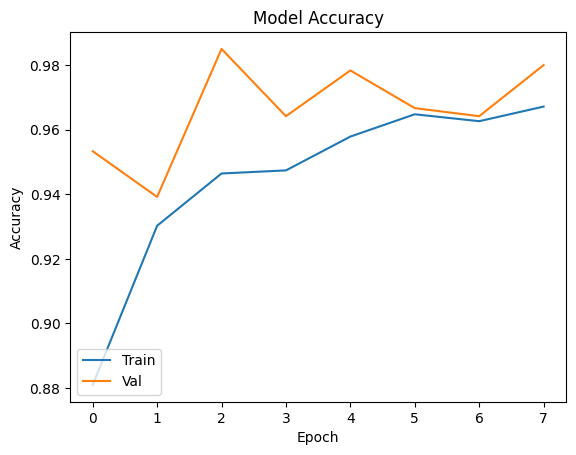

In [ ]:
# Graphique de l'accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "lower left")
plt.show()

### 4.2.7 Matrice de confusion

In [ ]:
# Prédire les valeurs à partir de l'ensemble de validation
Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)

# Convertir les classes des prédictions à partir de vecteurs one hot
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convertir les observations de validation à partir de vecteurs one hot
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OU
Y_true = test_generator.classes

# Calculer la matrice de confusion
cm = confusion_matrix(Y_true, Y_pred_classes)

# Afficher la matrice de confusion
print("Matrice de Confusion")
print(cm)

# Récupérer les noms de classe (étiquette)
noms_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(noms_from_dir))
# OU
class_names = list(val_generator.class_indices.keys())
# Vérifier si les deux sont similaires
print(noms_from_dir == class_names)

# Afficher le rapport de classification
print("Rapport de Classification")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names))


19/19 [==============================] - 8s 301ms/step
Confusion Matrix
[[200   0   0]
 [  3 197   0]
 [  4   1 195]]
True
Classification Report
                    precision    recall  f1-score   support

      BEE_SELECTED       0.97      1.00      0.98       200
BUTTERFLY_SELECTED       0.99      0.98      0.99       200
  LADYBUG_SELECTED       1.00      0.97      0.99       200

          accuracy                           0.99       600
         macro avg       0.99      0.99      0.99       600
      weighted avg       0.99      0.99      0.99       600



### 4.2.8 Création d'une fonction pour la matrice de confusion

In [ ]:
def plot_confusion_matrix(
    cm,
    classes,
    normalize = False,
    title = "Matrice de confusion",
    cmap = plt.cm.Blues):
    """
    Cette fonction affiche et trace la matrice de confusion.
    La normalisation peut être appliquée en définissant `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    print(cm)
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel("Étiquette réelle")
    plt.xlabel("Étiquette prédite")


### 4.2.9 Affichage de la matrice de confusion sous forme de graphique

Normalized confusion matrix
[[1.    0.    0.   ]
 [0.015 0.985 0.   ]
 [0.02  0.005 0.975]]


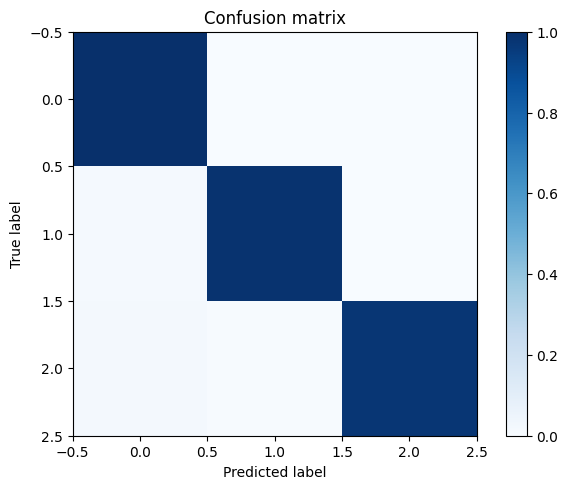

In [ ]:
plot_confusion_matrix(
    cm,
    class_names,
    normalize = True,
    title = "Matrice de confusion",
    cmap = plt.cm.Blues
    )

## 5. Fine Tuning
Cela nécessite de débloquer le modèle de base, puis de recompiler le modèle (nécessaire pour que les changements prennent effet), et ensuite de reprendre l'entraînement.


### 5.1. Unfreeze le modèle de base

In [ ]:
# Unfreeze le modèle de base
base_model.trainable = True

### 5.2 Re compilation du modèle

In [ ]:
model.compile(
    optimizer = ft_compile_optimizer,
    loss = ft_compile_loss,
    metrics = ft_compile_metrics
)

### 5.3 Ré-entrainement du modèle

In [ ]:
# Reprendre l'entraînement
ft_history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = ft_epochs,
    verbose = ft_verbose,
    callbacks = ft_callbacks_list
)

# Sauvegarder le modèle affiné
model.save(ft_fileh5_path)


Epoch 1/15
132/132 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9664 - Precision: 0.9727 - Recall: 0.9635 - AUC: 0.9952
Epoch 1: val_loss improved from inf to 0.04212, saving model to /content/drive/MyDrive/EfficientNetV2B1_H5_Model/EfficientNetV2B1_FT_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 167s 916ms/step - loss: 0.1204 - accuracy: 0.9664 - Precision: 0.9727 - Recall: 0.9635 - AUC: 0.9952 - val_loss: 0.0421 - val_accuracy: 0.9867 - val_Precision: 0.9883 - val_Recall: 0.9842 - val_AUC: 0.9995 - lr: 1.0000e-05
Epoch 2/15
132/132 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9655 - Precision: 0.9711 - Recall: 0.9593 - AUC: 0.9955
Epoch 2: val_loss did not improve from 0.04212
132/132 [==============================] - 120s 905ms/step - loss: 0.1175 - accuracy: 0.9655 - Precision: 0.9711 - Recall: 0.9593 - AUC: 0.9955 - val_loss: 0.0466 - val_accuracy: 0.9850 - val_Precision: 0.9883 - val_Recall: 0.9825 - val_AUC: 0.9995 - lr: 1.0000e-05
Epoch 3/15
132/132 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9729 - Precision: 0.9774 - Recall: 0.9681 - AUC: 0.9967
Epoch 3: val_loss improved from 0.04212 to 0.04167, saving model to /content/drive/MyDrive/EfficientNetV2B1_H5_Model/EfficientN

### 5.3.1 Evaluation du Fine Tune Model

In [ ]:
# Évaluer le modèle sur les données de test en utilisant `evaluate`
print("Évaluation sur les données de test")
results = model.evaluate(test_generator, batch_size = batch_size)


Evaluate on Test Data
19/19 [==============================] - 4s 218ms/step - loss: 0.0328 - accuracy: 0.9900 - Precision: 0.9950 - Recall: 0.9883 - AUC: 0.9998


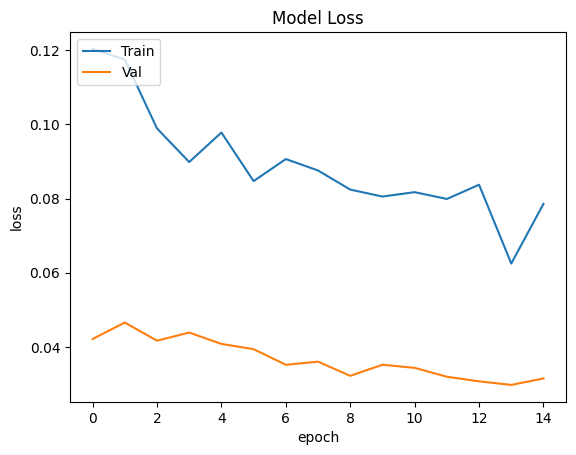

In [ ]:
# Tracer le graphique de la perte
plt.plot(ft_history.history["loss"])
plt.plot(ft_history.history["val_loss"])
plt.title("Perte du Modèle")
plt.ylabel("perte")
plt.xlabel("époque")
plt.legend(["Entraînement", "Validation"], loc = "upper left")
plt.show()


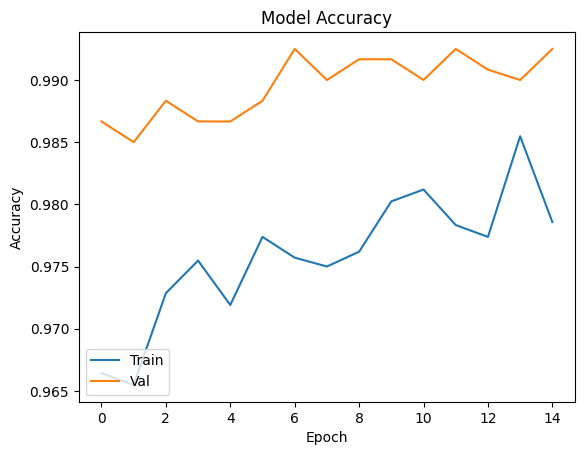

In [ ]:
# Tracer le graphique de la précision
plt.plot(ft_history.history["accuracy"])
plt.plot(ft_history.history["val_accuracy"])
plt.title("Précision du Modèle")
plt.ylabel("Précision")
plt.xlabel("Époque")
plt.legend(["Entraînement", "Validation"], loc = "lower left")
plt.show()


### 5.3.2 Matrice de confusion du Fine Tuned Model

In [ ]:
# Prédire les valeurs à partir de l'ensemble de validation
Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)

# Convertir les classes des prédictions à partir de vecteurs one hot
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convertir les observations de validation à partir de vecteurs one hot
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OU
Y_true = test_generator.classes

# Calculer la matrice de confusion
cm = confusion_matrix(Y_true, Y_pred_classes)

# Afficher la matrice de confusion
print("Matrice de Confusion")
print(cm)

# Récupérer les noms de classe (étiquette)
noms_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(noms_from_dir))
# OU
class_names = list(val_generator.class_indices.keys())
# Vérifier si les deux sont similaires
print(noms_from_dir == class_names)

# Afficher le rapport de classification
print("Rapport de Classification")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names, digits = 4))


19/19 [==============================] - 7s 384ms/step
Confusion Matrix
[[200   0   0]
 [  3 197   0]
 [  1   2 197]]
True
Classification Report
                    precision    recall  f1-score   support

      BEE_SELECTED     0.9804    1.0000    0.9901       200
BUTTERFLY_SELECTED     0.9899    0.9850    0.9875       200
  LADYBUG_SELECTED     1.0000    0.9850    0.9924       200

          accuracy                         0.9900       600
         macro avg     0.9901    0.9900    0.9900       600
      weighted avg     0.9901    0.9900    0.9900       600



### 5.3.3 Graphique de la Matrice de confusion concernant le Fine Tuned Model

Normalized confusion matrix
[[1.    0.    0.   ]
 [0.015 0.985 0.   ]
 [0.005 0.01  0.985]]


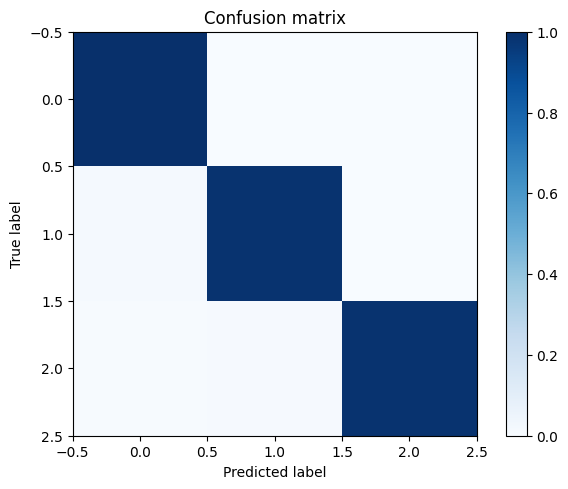

In [ ]:
plot_confusion_matrix(cm,
                      class_names,
                      normalize = True,
                      title = "Matrice de confusion",
                      cmap = plt.cm.Blues
                      )

### 5.3.4 Quelques métriques du modèle affiné


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcul de la précision
precision = precision_score(test_generator.classes, Y_pred_classes, average='macro') # average macro, calcul individuel par classe attribut le même poids à chaque classe
# Calcul du recall
recall = recall_score(test_generator.classes, Y_pred_classes, average='macro')

# Calcul du F1 score
f1 = f1_score(test_generator.classes, Y_pred_classes, average='macro')

# Affichage des résultats
print("Précision :", precision)
print("Recall :", recall)
print("F1 score :", f1)

Précision : 0.9901139685354878
Recall : 0.9899999999999999
F1 score : 0.9900036688390719


In [ ]:
# Calcul de la précision
precision = precision_score(test_generator.classes, Y_pred_classes, average='weighted')
# average Weighted, calcul individuel par classe pour pondéré en fonction du poids de chaque classe

# Calcul du recall
recall = recall_score(test_generator.classes, Y_pred_classes, average='weighted')

# Calcul du F1 score
f1 = f1_score(test_generator.classes, Y_pred_classes, average='weighted')

# Affichage des résultats
print("Précision :", precision)
print("Recall :", recall)
print("F1 score :", f1)

Précision : 0.9901139685354879
Recall : 0.99
F1 score : 0.9900036688390719


In [ ]:
precision = precision_score(test_generator.classes, Y_pred_classes, average='micro')
# average micro, Calcule la précision globale en agrégeant les vrais positifs, faux positifs et faux négatifs sur toutes les classes

# Calcul du recall
recall = recall_score(test_generator.classes, Y_pred_classes, average='micro')

# Calcul du F1 score
f1 = f1_score(test_generator.classes, Y_pred_classes, average='micro')

# Affichage des résultats
print("Précision :", precision)
print("Recall :", recall)
print("F1 score :", f1)

Précision : 0.99
Recall : 0.99
F1 score : 0.99
